In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [2]:
IMAGE_SHAPE = (224, 224)

In [3]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
training_data='/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train'
training_image_data  = image_generator.flow_from_directory(training_data,target_size=IMAGE_SHAPE)

Found 2076 images belonging to 2 classes.


In [4]:
training_image_data[1][1].shape

(32, 2)

In [5]:
validation_data='/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid'
validation_image_data  = image_generator.flow_from_directory(validation_data,target_size=IMAGE_SHAPE)

Found 531 images belonging to 2 classes.


In [6]:
class_names = sorted(training_image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Dr', 'No_Dr'], dtype='<U5')

In [7]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(2,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
conv_base.trainable = False

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
for image_batch, label_batch in training_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)


In [14]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
history = model.fit(training_image_data, epochs = 8,
                          validation_data=validation_image_data)

Epoch 1/8


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727894686.783294     355 service.cc:145] XLA service 0x7c9ec4012270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727894686.783354     355 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727894686.783358     355 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/65 ━━━━━━━━━━━━━━━━━━━━ 18:04 17s/step - accuracy: 0.7188 - loss: 1.1386

I0000 00:00:1727894700.897330     355 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 ━━━━━━━━━━━━━━━━━━━━ 54s 580ms/step - accuracy: 0.7598 - loss: 1.9334 - val_accuracy: 0.9379 - val_loss: 0.1733
Epoch 2/8
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.9321 - loss: 0.2060 - val_accuracy: 0.9322 - val_loss: 0.2476
Epoch 3/8
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 176ms/step - accuracy: 0.9521 - loss: 0.1584 - val_accuracy: 0.9379 - val_loss: 0.2442
Epoch 4/8
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.9637 - loss: 0.1261 - val_accuracy: 0.9379 - val_loss: 0.1456
Epoch 5/8
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.9659 - loss: 0.0998 - val_accuracy: 0.9416 - val_loss: 0.1394
Epoch 6/8
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.9745 - loss: 0.0915 - val_accuracy: 0.9058 - val_loss: 0.2527
Epoch 7/8
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.9494 - loss: 0.1463 - val_accuracy: 0.9397 - val_loss: 0.2009
Epoch 8/8
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step - accuracy: 0.9666 - loss: 0.1196 - val_accuracy: 0.9454 - val

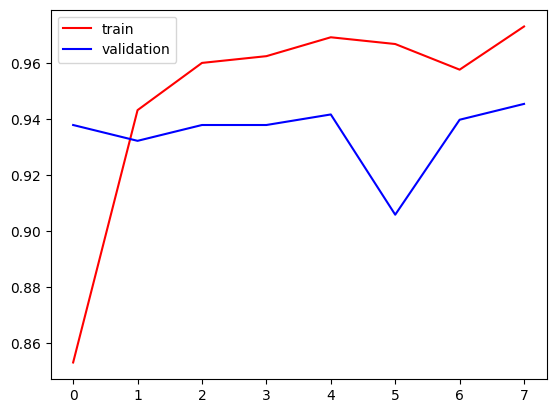

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

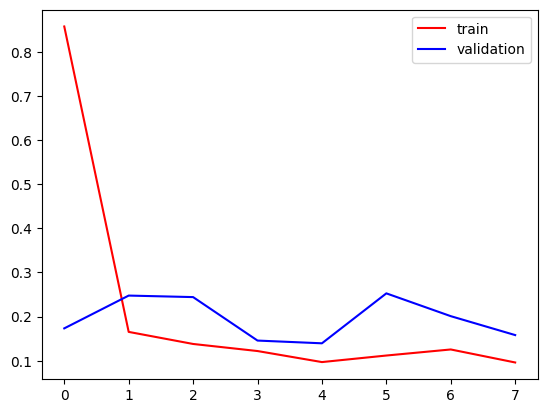

In [17]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [18]:
arr = model.predict(image_batch)
predicted_id = np.argmax(arr, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)
true_label_batch = class_names[label_id]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step


In [19]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_data='/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test'
test_image_data  = image_generator.flow_from_directory(test_data,target_size=IMAGE_SHAPE, batch_size=150)

Found 231 images belonging to 2 classes.


In [20]:
for image_batch, label_batch in test_image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (150, 224, 224, 3)
Label batch shape:  (150, 2)


In [21]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(label_batch, axis=-1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step 


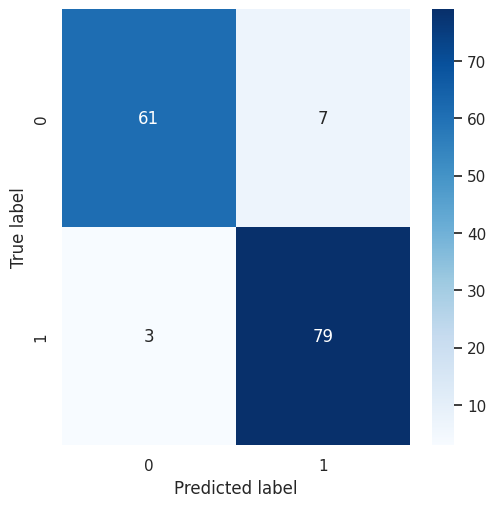

In [22]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()

con_mat_df=tf.math.confusion_matrix(
    labels = label_id , predictions = predicted_id
)

figure = plt.figure(figsize=(5, 5))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
from sklearn.metrics import classification_report
print(classification_report(label_id, predicted_id, zero_division=0))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        68
           1       0.92      0.96      0.94        82

    accuracy                           0.93       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



In [24]:
model.save('B-DR-VGG16.h5')
model.save('B-DR-VGG16.keras')